<a href="https://colab.research.google.com/github/pgdinamica/deeplearning/blob/main/notebooks/RedesConvolucionais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# II Redes Neurais Convolucionais
Material da aula realizada no canal Programação Dinâmica no dia 16 de outubro de 2021. Confira a gravação da aula abaixo.

In [1]:
from IPython.display import HTML
HTML('''<iframe width="560" height="315" 
        src="https://www.youtube.com/embed/doT7koXt9vw" 
        frameborder="0" allow="accelerometer; autoplay; encrypted-media; 
        gyroscope; picture-in-picture" allowfullscreen></iframe>''')

As redes convolucionais ou redes de convolução têm sido aplicadas com muito sucesso em tarefas relacionadas a imagens. Nesta aula, entenderemos a ideia por trás deste tipo de arquitetura de rede neural e resolveremos um problema de classificação binária de imagens.


# Preparando o Conjunto de Dados

Vamos usar um conjunto de dados de imagens clássico chamado CIFAR10. Este conjunto....



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import matplotlib.pyplot as plt
import os

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.datasets import CIFAR10

In [56]:
BASE_DIR = '/content/drive/MyDrive/datasets'
DATA_DIR = '/content/drive/MyDrive/datasets/cifar10'
CATEGORIES = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
def get_path(relpath):
  return os.path.join(BASE_DIR, relpath)

In [4]:
cifar10_train = CIFAR10(DATA_DIR, train=True, download=True)
cifar10_test = CIFAR10(DATA_DIR, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
(len(cifar10_train), len(cifar10_test))

(50000, 10000)

## Vamos visualizar algumas imagens dos dados

In [6]:
def lookat_dataset(dataset, istensor=False):
  figure = plt.figure(figsize=(8, 8))
  rows, cols = 2, 2
  for i in range(1, 5):
      sample_idx = torch.randint(len(dataset), size=(1,)).item()
      img, label = dataset[sample_idx]
      figure.add_subplot(rows, cols, i)
      plt.title(CATEGORIES[label])
      plt.axis("off")
      if istensor:
        plt.imshow(img.squeeze().permute(1, 2, 0))
      else:
        plt.imshow(img)
  plt.show()

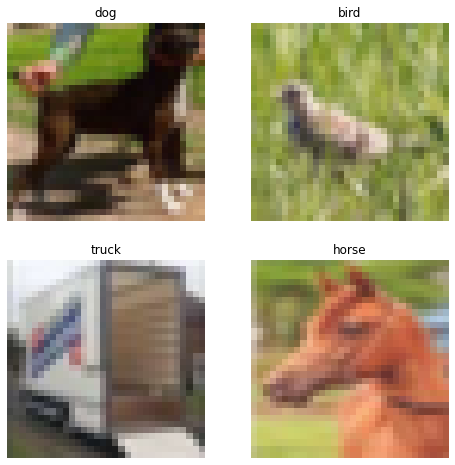

In [7]:
lookat_dataset(cifar10_train)

# Aplicando transformações e dividindo os dados

In [8]:
prep_transform = T.Compose([
                    T.ToTensor(),
                    T.Normalize(
                        (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)
                    )
                  ])

# Applying a transform
tensor_train = CIFAR10(DATA_DIR, train=True, download=False,
                         transform=prep_transform)
tensor_test = CIFAR10(DATA_DIR, train=False, download=False,
                         transform=prep_transform)


In [ ]:
# Normalizing data
imgs = torch.stack([img_t for img_t, _ in tensor_train], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [ ]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [ ]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


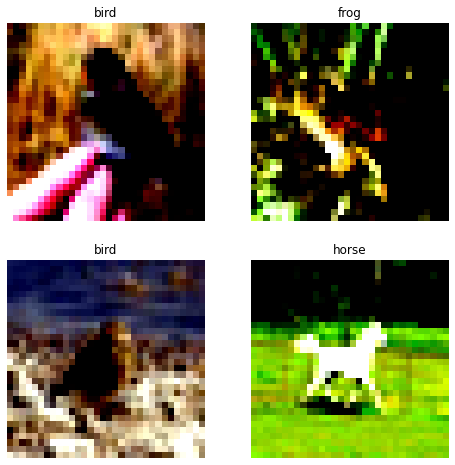

In [9]:
lookat_dataset(tensor_train, True)

## Criando DataLoaders

In [10]:
batch_size = 64
train_loader = DataLoader(tensor_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tensor_test, batch_size=batch_size, shuffle=False)

# Construindo uma rede MLP 

MLP = MultiLayer Perceptron (multi camadas de perceptrons)

In [11]:
from torch import nn

In [12]:
class MLPClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    
    self.layers = nn.Sequential(
        nn.Linear(3 * 32*32, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10),
    )

  def forward(self, x):
    v = self.flatten(x)
    return self.layers(v)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

Rodando na cuda


In [14]:
model = MLPClassifier().to(device)

## Escolhendo os hiperparâmetros de otimização

In [15]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [16]:
def train(model, dataloader, loss_func, optimizer):
  model.train()
  cumloss = 0.0

  for imgs, labels in dataloader:
    imgs, labels = imgs.to(device), labels.to(device)
    
    optimizer.zero_grad()

    pred = model(imgs)

    loss = loss_func(pred, labels)
    loss.backward()
    optimizer.step()

    cumloss += loss.item()

  return cumloss / len(dataloader)

def validate(model, dataloader, loss_func):
  model.eval()
  cumloss = 0.0

  with torch.no_grad():
    for imgs, labels in dataloader:
      imgs, labels = imgs.to(device), labels.to(device)

      pred = model(imgs)
      loss = loss_func(pred, labels)
      cumloss += loss.item()

  return cumloss / len(dataloader)

In [17]:
# Aprenda sobre Matplotlib com a Kizzy: https://youtu.be/iSpi3rKdoLQ
# Introdução ao Matplotlib | Gráficos em Python | Análise de dados #7 
def plot_losses(losses):
  fig = plt.figure(figsize=(13, 5))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():  
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16");

## Treinando a rede

In [18]:
epochs = 41
train_losses = []
test_losses = []
for t in range(epochs):
  train_loss = train(model, train_loader, loss_func, optimizer)
  train_losses.append(train_loss)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
  
  test_loss = validate(model, test_loader, loss_func)
  test_losses.append(test_loss)

Epoch: 0; Train Loss: 2.295573089433753
Epoch: 10; Train Loss: 1.843485198362404
Epoch: 20; Train Loss: 1.6313182345741546
Epoch: 30; Train Loss: 1.4990385752504745
Epoch: 40; Train Loss: 1.3941105209348146
Epoch: 50; Train Loss: 1.3019757812742687


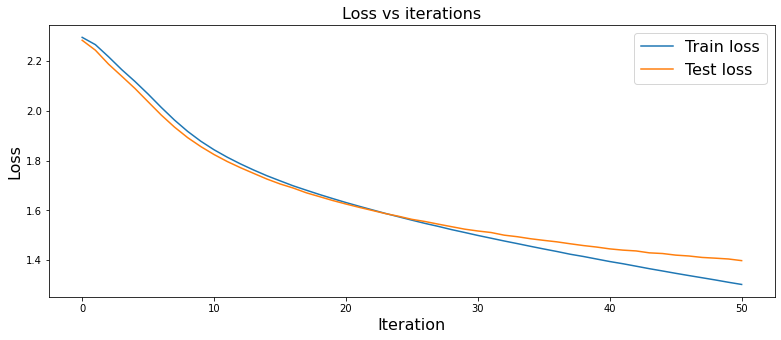

In [19]:
losses = {"Train loss": train_losses, "Test loss": test_losses}
plot_losses(losses)

# Avaliando o resultado

In [66]:
HTML('''<iframe width="560" height="315" 
        src="https://www.youtube.com/embed/ePZswmBSLvc" 
        frameborder="0" allow="accelerometer; autoplay; encrypted-media; 
        gyroscope; picture-in-picture" allowfullscreen></iframe>''')

In [20]:
def make_confusion_matrix(model, loader, n_classes):
  confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int64)
  with torch.no_grad():
    for i, (imgs, labels) in enumerate(loader):
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs)
      _, predicted = torch.max(outputs, 1)
      for t, p in zip(torch.as_tensor(labels, dtype=torch.int64).view(-1), 
                      torch.as_tensor(predicted, dtype=torch.int64).view(-1)):
        confusion_matrix[t, p] += 1
  return confusion_matrix

def evaluate_accuracy(model, dataloader, classes, verbose=True):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  confusion_matrix = make_confusion_matrix(model, dataloader, len(classes))
  if verbose:
    total_correct = 0.0
    total_prediction = 0.0
    for i, classname in enumerate(classes):
      correct_count = confusion_matrix[i][i].item()
      class_pred = torch.sum(confusion_matrix[i]).item()

      total_correct += correct_count
      total_prediction += class_pred

      accuracy = 100 * float(correct_count) / class_pred
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print("Global acccuracy is {:.1f}".format(100 * total_correct/total_prediction))
  return confusion_matrix

def test(model, dataloader, classes):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # again no gradients needed
  with torch.no_grad():
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

  # print accuracy for each class
  total_correct = 0.0
  total_prediction = 0.0
  for classname, correct_count in correct_pred.items():
      total_correct += correct_count
      total_prediction += total_pred[classname]
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print("Global acccuracy is {:.1f}".format(100 * total_correct/total_prediction))



In [21]:
confusion_matrix = evaluate_accuracy(model, test_loader, CATEGORIES)

Accuracy for class airplane is: 54.0 %
Accuracy for class automobile is: 61.1 %
Accuracy for class bird  is: 34.6 %
Accuracy for class cat   is: 32.7 %
Accuracy for class deer  is: 38.7 %
Accuracy for class dog   is: 37.6 %
Accuracy for class frog  is: 59.1 %
Accuracy for class horse is: 58.8 %
Accuracy for class ship  is: 66.4 %
Accuracy for class truck is: 59.2 %
Global acccuracy is 50.2


In [22]:
import seaborn as sn
# Confira: https://seaborn.pydata.org/generated/seaborn.heatmap.html
# Aprenda a interpretar heatmaps: https://youtu.be/kEQAY4gcSd0

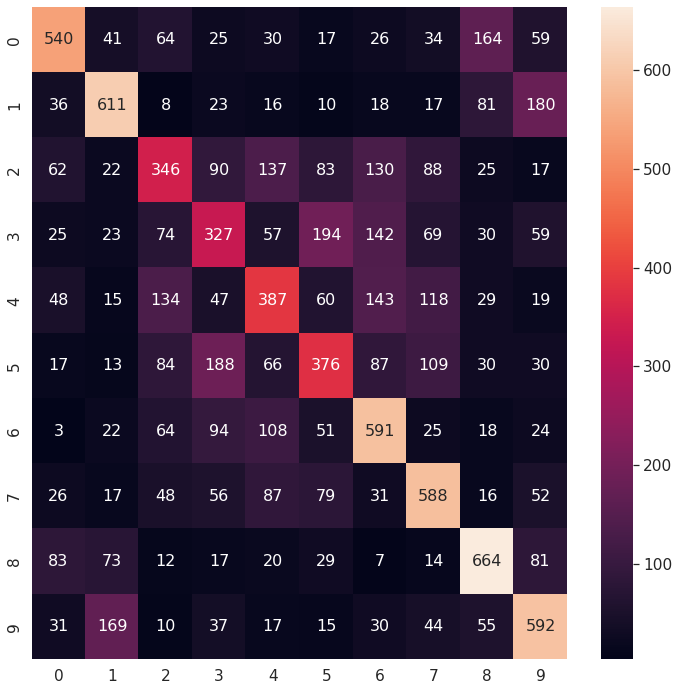

In [23]:
plt.figure(figsize=(12, 12))
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix.tolist(), 
           annot=True, annot_kws={"size": 16}, fmt='d')

# Construindo uma rede neural de convolução

In [24]:
class ConvolutionalModel(nn.Module):
  def __init__(self):
      super().__init__()
      self.convlayers = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(16, 32, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

      )

      self.linearlayers = nn.Sequential(
          nn.Linear(1152, 256),
          nn.ReLU(),
          nn.Linear(256, 10)
      )

  def forward(self, x):
      x = self.convlayers(x)
      x = torch.flatten(x, 1)
      return self.linearlayers(x)

In [25]:
convmodel = ConvolutionalModel().to(device)

In [26]:
loss_func2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(convmodel.parameters(), lr=0.001)

In [27]:
epochs = 51
conv_train_losses = []
conv_test_losses = []
for t in range(epochs):
  train_loss = train(convmodel, train_loader, loss_func2, optimizer2)
  conv_train_losses.append(train_loss)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
  test_loss = validate(convmodel, test_loader, loss_func)
  conv_test_losses.append(test_loss)  

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0; Train Loss: 2.294246600716925
Epoch: 10; Train Loss: 1.746702816175378
Epoch: 20; Train Loss: 1.4939220918109044
Epoch: 30; Train Loss: 1.3560881933287892
Epoch: 40; Train Loss: 1.233905482170222
Epoch: 50; Train Loss: 1.1435625112575034


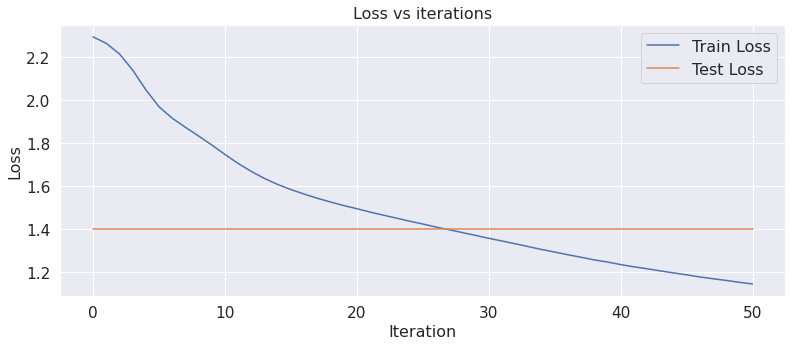

In [28]:
conv_losses = {"Train Loss": conv_train_losses, "Test Loss": conv_test_losses}
plot_losses(conv_losses)

In [29]:
conv_confusion_matrix = evaluate_accuracy(convmodel, test_loader, CATEGORIES)

Accuracy for class airplane is: 77.3 %
Accuracy for class automobile is: 73.4 %
Accuracy for class bird  is: 42.0 %
Accuracy for class cat   is: 39.0 %
Accuracy for class deer  is: 48.5 %
Accuracy for class dog   is: 50.3 %
Accuracy for class frog  is: 69.4 %
Accuracy for class horse is: 65.4 %
Accuracy for class ship  is: 67.7 %
Accuracy for class truck is: 55.8 %
Global acccuracy is 58.9


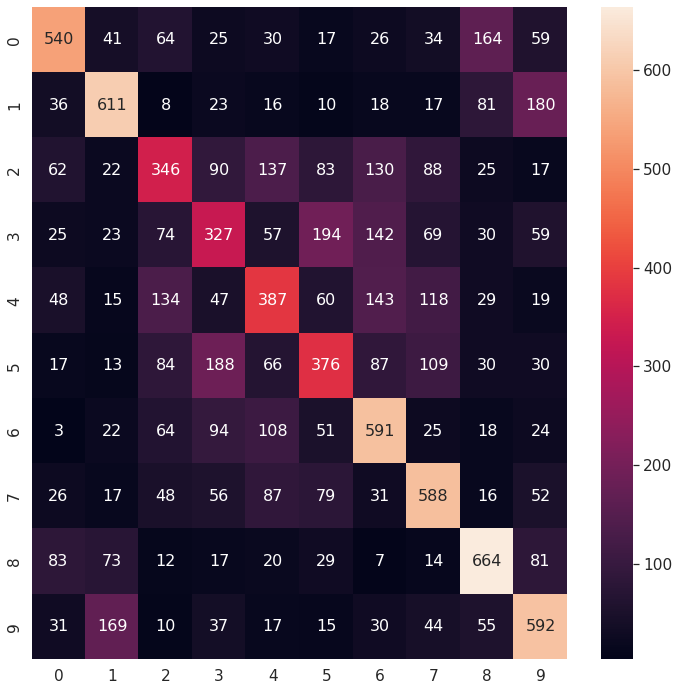

In [30]:
plt.figure(figsize=(12, 12))
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix.tolist(), 
           annot=True, annot_kws={"size": 16}, fmt='d')

# Testando em exemplos próprios

In [31]:
from PIL import Image

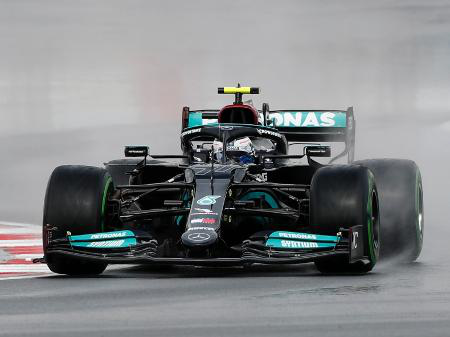

In [57]:
img = Image.open(get_path('avulsas/carrof1.jpeg'))
img

In [49]:
prep_transforms = T.Compose(
    [T.Resize((32, 32)),
     T.ToTensor(),
     T.Normalize( (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616) )
     ]
)
img_tensor = prep_transforms(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


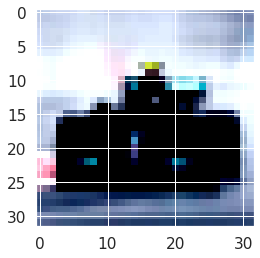

In [50]:
plt.imshow(img_tensor.permute(1,2, 0))

In [51]:
batch = img_tensor.unsqueeze(0).to(device)

In [52]:
convmodel.eval()

ConvolutionalModel(
  (convlayers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linearlayers): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [53]:
output = convmodel(batch)
output

tensor([[ 1.0577,  4.1914, -0.7316,  0.1285, -0.5799, -1.7476,  0.7314, -2.5384,
          1.5410,  2.7182]], device='cuda:0', grad_fn=<AddmmBackward>)

In [54]:
logits = torch.nn.functional.softmax(output, dim=1) * 100
for i, classname in enumerate(CATEGORIES):
  print(f"{classname} score: {logits[0][i].item():.2f}")

airplane score: 3.09
automobile score: 70.84
bird score: 0.52
cat score: 1.22
deer score: 0.60
dog score: 0.19
frog score: 2.23
horse score: 0.08
ship score: 5.00
truck score: 16.24


# Quero maaaaaaais!!!!

In [58]:
HTML('''<iframe width="560" height="315" 
        src="https://www.youtube.com/embed/HW7oJVqqQxU"
        frameborder="0" allow="accelerometer; autoplay; encrypted-media; 
        gyroscope; picture-in-picture" allowfullscreen></iframe>''')




1. [Tutoriais do PyTorch](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)
2. Playlist [Machine Learning com Python](https://youtube.com/playlist?list=PL5TJqBvpXQv5CBxLkdqmou_86syFK7U3Q)
2. [Playlist de Processamento de Imagens](https://www.youtube.com/playlist?list=PL5TJqBvpXQv54i_HWjd7s70vbP4Is7sK_) (Programação Dinâmica)
2. [Canal peixe Babel](https://youtu.be/Vfzm1-cfLuc)
3. [Canal Universo Discreto](https://www.youtube.com/watch?v=gbrHEsbTdF0&t=2045s)
4. [Livro Deep Learning](https://www.deeplearningbook.org), Ian GoodFellow
5. [Fundamentos e Tendências em Visão e Processamento de Imagens](https://www.youtube.com/playlist?list=PLo4jXE-LdDTRaFa39TdNN3FgPAKkcuHvj) (Curso do IMPA)
7. Playlist [Diário de Pesquisa](https://youtube.com/playlist?list=PL5TJqBvpXQv4xUJmvSPrP2WI--e5KIgux)